In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy

import matplotlib.patches as mpatches



import matplotlib.colors as clr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import collections  as mc
import matplotlib.lines as mlines

In [2]:
pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
!pwd

/home/fran/Documents/cuppen/code/code/escape_mutations/code_review/gie_prevalence


In [4]:
df_primary = pd.read_csv("../results/data/processed_pcawg_escape_info.tsv.gz",sep="\t")
df_met = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t")
summary_cohort = pd.read_csv("../metadata/table_cancer_types_info.tsv",sep="\t")

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Save combined dataset

In [5]:
df_comb = pd.concat([df_primary,df_met])
#df_comb = df_comb.merge(pd.read_csv("../metadata/dataset_metadata.tsv",sep="\t")[["sample_id","cohort"]].rename(columns={"sample_id":"sampleId"}))
df_comb.shape

(6319, 153)

### Ratio of metastatic samples

In [6]:
pallete = {"wt":"#ef8a62","alteration":"#67a9cf","alteration_primary":"#7570b3"}

### Total

In [7]:
features = ["targeted_app_pathway_mut_HLA","targeted_app_pathway_partdel_HLA","systemic_app_pathway","ifn_gamma_pathway","checkpoint_pathway","cd58_pathway","epigenetic_regulators_pathway","genetic_immune_escape"]
names = ["Somatic mutation HLA","LOH/partial del. HLA","Antigen presentation pathway","IFN-gamma pathway", "PD-L1 amplification","CD58 alteration","Epigenetic regulation by SETDB1","Genetic immune escape \n (GIE)"]

### Selected ttypes

In [8]:
ttypes_selected = summary_cohort[summary_cohort["hmf_and_pcawg"]]["cancer_type"]

In [9]:
def ratio(grp):
    total = len(grp)
    return sum(grp) / total
d_counts_ttype_met=df_met.groupby(["cancer_type"]).agg({"sample_id":"count"}).to_dict()["sample_id"]
d_counts_ttype_primary=df_primary.groupby(["cancer_type"]).agg({"sample_id":"count"}).to_dict()["sample_id"]

In [10]:
ratio_met=df_met[df_met["cancer_type"].isin(ttypes_selected)].groupby(["cancer_type","cancer_type_code"],as_index=False).agg({"epigenetic_regulators_pathway":ratio,"cd58_pathway":ratio,"systemic_app_pathway":ratio,"targeted_app_pathway_mut_HLA":ratio,"targeted_app_pathway_partdel_HLA":ratio,"ifn_gamma_pathway":ratio,"checkpoint_pathway":ratio,"genetic_immune_escape":ratio,"sample_id":"count"}).rename(columns={"sample_id":"n_samples"})
ratio_primary=df_primary[df_primary["cancer_type"].isin(ttypes_selected)].groupby(["cancer_type","cancer_type_code"],as_index=False).agg({"epigenetic_regulators_pathway":ratio,"cd58_pathway":ratio,"systemic_app_pathway":ratio,"targeted_app_pathway_mut_HLA":ratio,"targeted_app_pathway_partdel_HLA":ratio,"ifn_gamma_pathway":ratio,"checkpoint_pathway":ratio,"genetic_immune_escape":ratio,"sample_id":"count"}).rename(columns={"sample_id":"n_samples"})


### Plot it as scatter

### Compare primary versus metastatic

In [23]:
comparison_basic=ratio_primary.rename(columns=dict([[x,x+"_primary"] for x in ratio_primary.columns.values])).reset_index().merge(ratio_met.reset_index())
comparison_basic.set_index(["cancer_type","cancer_type_code"],inplace=True)

### Compute significance

In [24]:
r=[]
for ttype in set(comparison_basic.index):
    q=comparison_basic.loc[ttype]
    # met samples
    escaped_met=int(q["n_samples"]*q["genetic_immune_escape"])
    non_escaped_met=int(q["n_samples"] - escaped_met)
    # primary samples
    escaped_primary=int(int(q["n_samples_primary"])*q["genetic_immune_escape_primary"])
    non_escaped_primary=int(q["n_samples_primary"]) - escaped_primary
  
    odds_ratio,pvalue=stats.fisher_exact([[escaped_met,non_escaped_met],[escaped_primary,non_escaped_primary]])
    
    r.append([q.name[0],q.name[1],odds_ratio,pvalue,escaped_met,non_escaped_met,escaped_primary,non_escaped_primary])
    
    
df_r_comparison_basic = pd.DataFrame(r,columns=["ttype","ttype_code","odds_ratio","pvalue","escaped_met","non_escaped_met","escaped_primary","non_escaped_primary"])

### Plot as scatter

In [25]:
import statsmodels.stats.multitest as st
def set_log2_odds(odd):
    if np.isinf(odd):
        return 5
    elif np.isnan(odd):
        return 0
    else:
        return np.log2(odd)
def set_size(row):
    if row["log2_odds_ratio"] > 0 and row["escaped_met"] > 1:
        return row["escaped_met"]**1.25 + 100
    elif row["log2_odds_ratio"] < 0 and row["escaped_primary"] > 1:
        return row["escaped_primary"]**1.25 + 100
    return 0

colors = [ pallete["alteration_primary"],"white",pallete["alteration"]]
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=256)


order=df_r_comparison_basic.sort_values("odds_ratio",ascending=False)["ttype"].values
order_inverse=df_r_comparison_basic.sort_values("odds_ratio",ascending=True)["ttype"].values
df_r_comparison_basic["log2_odds_ratio"]=df_r_comparison_basic.apply(lambda row: set_log2_odds(row["odds_ratio"]),axis=1)
minv=-2.0
maxv=2.0
df_r_comparison_basic["color"]= df_r_comparison_basic.apply(lambda row: cm((row["log2_odds_ratio"] - minv) / (maxv -minv) ),axis=1)
df_r_comparison_basic["qvalue"]=st.fdrcorrection(df_r_comparison_basic["pvalue"])[1]
df_r_comparison_basic.sort_values("qvalue").to_csv("../results/data/primary_vs_met_global_gie.tsv",sep="\t")
df_r_comparison_basic.sort_values("qvalue")




,ttype,ttype_code,odds_ratio,pvalue,escaped_met,non_escaped_met,escaped_primary,non_escaped_primary,log2_odds_ratio,color,qvalue
9,Thyroid cancer,THCA,inf,0.000245,7,15,0,43,5.000000,"(0.403921568627451, 0.6627450980392157, 0.8117...",0.002450
17,Prostate carcinoma,PRAD,4.252199,0.000189,60,341,6,145,2.088209,"(0.403921568627451, 0.6627450980392157, 0.8117...",0.002450
7,Uterus carcinoma,UCEC,13.500000,0.003739,11,22,1,27,3.754888,"(0.403921568627451, 0.6627450980392157, 0.8117...",0.024924
0,Kidney clear cell carcinoma,KIRC,2.187925,0.039251,31,98,12,83,1.129563,"(0.6610534409842368, 0.8082276047673972, 0.892...",0.196255
8,Esophagus cancer,ESCA,1.531974,0.155285,57,83,26,58,0.615392,"(0.8153325643983084, 0.895517108804306, 0.9416...",0.516813
13,Upper respiratory tract cancer,HNSC,0.534722,0.190236,14,24,24,22,-0.903138,"(0.7559400230680509, 0.7470972702806613, 0.865...",0.516813
15,Pancreas neuroendocrine,PANET,1.894737,0.159926,24,13,38,39,0.921997,"(0.7218300653594771, 0.8426143790849673, 0.912...",0.516813
3,Ovarian cancer,OV,1.744737,0.206725,51,114,10,39,0.803009,"(0.7592310649750096, 0.8637754709727028, 0.923...",0.516813
5,Pancreas carcinoma,PAAD,0.806131,0.433433,28,71,68,139,-0.310914,"(0.9172318339100347, 0.9142329873125721, 0.954...",0.673834
6,Skin melanoma,SKCM,0.803311,0.413715,66,237,26,75,-0.315970,"(0.9129873125720878, 0.909834678969627, 0.9520...",0.673834


In [27]:
df_r_comparison_basic[df_r_comparison_basic["log2_odds_ratio"]>0.5].shape

(9, 11)

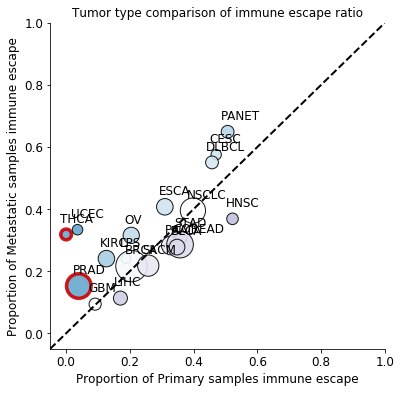

In [28]:
fig,ax=plt.subplots(figsize=(6,6))
xs,ys,size,sig,colors,edgecolors=[],[],[],[],[],[]
for ttype in order:
    q=comparison_basic.loc[ttype]
    xs.append(q["genetic_immune_escape_primary"])
    ys.append(q["genetic_immune_escape"])
    size.append(q["n_samples"]+q["n_samples_primary"]+50)
    colors.append(df_r_comparison_basic[df_r_comparison_basic["ttype"]==ttype]["color"].values[0])
    
    sig.append(int(df_r_comparison_basic[df_r_comparison_basic["ttype"]==ttype]["qvalue"]<.01)*2.5 + 1)
    edgecolors+=["#cc0000" if sig[-1]>1 else "black"]



for i,ttype in enumerate(order):
    ax.annotate(xy=(xs[i]-0.02,ys[i]+0.04),s=comparison_basic.loc[ttype].index[0],fontsize=12)
ax.set_title("Tumor type comparison of immune escape ratio",fontsize=12)
ax.set_ylabel("Proportion of Metastatic samples immune escape",fontsize=12)
ax.set_xlabel("Proportion of Primary samples immune escape",fontsize=12)
ax.plot([0,0],[1,1])
ax.set_ylim(-0.05,1.0)
ax.set_xlim(-0.05,1.0)

ax.plot([0, 1], [0, 1], transform=ax.transAxes,lw=2,ls="--",color="black")
ax.tick_params(axis='both', which='major', labelsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



ax.scatter(x=xs,y=ys,s=size,lw=sig,edgecolor=edgecolors,alpha=.90,c=colors)#color=colors,
plt.savefig(f'../results/figures/figure2/met_vs_primary_scatter.pdf', dpi=800,bbox_inches="tight")




In [29]:
comparison_basic["n_samples"]+comparison_basic["n_samples_primary"]

cancer_type                     cancer_type_code
Breast cancer                   BRCA                938
Cervix carcinoma                CESC                 57
Colorectum carcinoma            COREAD              662
Diffuse large B-cell lymphoma   DLBCL               114
Esophagus cancer                ESCA                224
Glioblastoma multiforme         GBM                  97
Hepatocellular carcinoma        LIHC                147
Kidney clear cell carcinoma     KIRC                224
Liposarcoma                     LPS                  41
Non small cell lung cancer      NSCLC               587
Ovarian cancer                  OV                  214
Pancreas carcinoma              PAAD                306
Pancreas neuroendocrine         PANET               114
Prostate carcinoma              PRAD                552
Skin melanoma                   SKCM                404
Stomach cancer                  STAD                 96
Thyroid cancer                  THCA                 65

### Show comparison by type of alteration

##### Compute significance

In [30]:
r=[]
for column in features:
    for ttype,ttype_code in set(comparison_basic.index):
        q=comparison_basic.loc[(ttype,ttype_code)]
        # met samples
        escaped_met=int(q["n_samples"]*q[column])
        non_escaped_met=int(q["n_samples"] - escaped_met)
        # primary samples
        escaped_primary=int(int(q["n_samples_primary"])*q[column+"_primary"])
        non_escaped_primary=int(q["n_samples_primary"]) - escaped_primary

        odds_ratio,pvalue=stats.fisher_exact([[escaped_met,non_escaped_met],[escaped_primary,non_escaped_primary]])
    
        r.append([ttype,ttype_code,column,odds_ratio,pvalue,escaped_met,non_escaped_met,escaped_primary,non_escaped_primary])
    
    
df_r_comparison_basic = pd.DataFrame(r,columns=["ttype","ttype_code","column","odds_ratio","pvalue","escaped_met","non_escaped_met","escaped_primary","non_escaped_primary"])
df_r_comparison_basic["qvalue"]=st.fdrcorrection(df_r_comparison_basic["pvalue"])[1]

In [31]:
df_r_comparison_basic["log2_odds_ratio"]=df_r_comparison_basic.apply(lambda row: set_log2_odds(row["odds_ratio"]),axis=1)
minv=-1.0
maxv=1.0
df_r_comparison_basic["color"]= df_r_comparison_basic.apply(lambda row: cm((row["log2_odds_ratio"] - minv) / (maxv -minv) ),axis=1)
df_r_comparison_basic["size"] = df_r_comparison_basic.apply(lambda row: set_size(row),axis=1)
df_r_comparison_basic["sig"] = df_r_comparison_basic.apply(lambda row: row["qvalue"]<0.05,axis=1)
df_r_comparison_basic.set_index(["ttype","column"],inplace=True)

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log2
  


In [32]:
df_r_comparison_basic.to_csv("../results/data/primary_vs_met_gie_per_pathway.tsv",sep="\t")

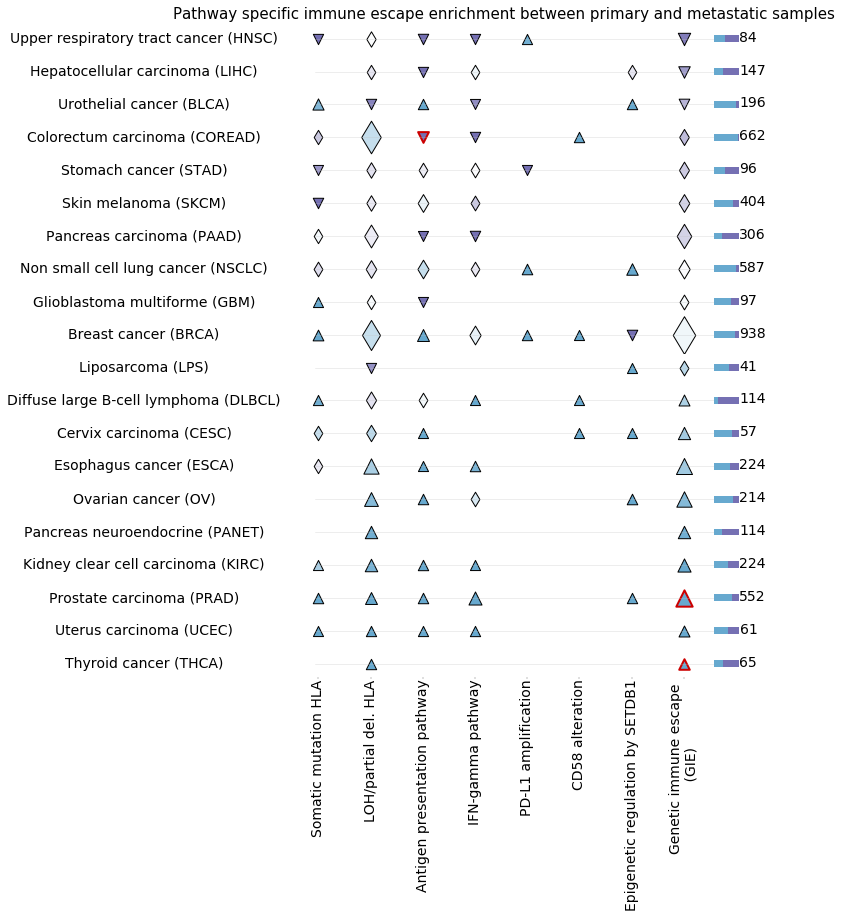

In [33]:
fig,ax=plt.subplots(figsize=(8,12))
N=len(order)
gs = gridspec.GridSpec(ncols=2,nrows=N,height_ratios=[1 for x in range(0,len(order))],width_ratios=[16,1],wspace=0.0)
ax0 = plt.subplot(gs[0]) 
ax1 = plt.subplot(gs[1]) 
axis = [ax0,ax1]
len_columns=len(features)
for i in range(2,N*2,2):
    axis.append(plt.subplot(gs[i],sharex=ax0))
    axis.append(plt.subplot(gs[i+1],sharey=axis[-1]))
i = 0
for j in range(0,len(order)*2,2):
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    ttype_s = order_inverse[i]
    code=df_r_comparison_basic.loc[ttype_s].loc[features]["ttype_code"].values[0]
    v=df_r_comparison_basic.loc[ttype_s].loc[features]["color"].values
    sizes=df_r_comparison_basic.loc[ttype_s].loc[features]["size"].values
    lw=[2 if x else 1  for x in  df_r_comparison_basic.loc[ttype_s].loc[features]["sig"].values]
    edgecolors=["#cc0000" if x else "black"  for x in  df_r_comparison_basic.loc[ttype_s].loc[features]["sig"].values]
    odds=df_r_comparison_basic.loc[ttype_s].loc[features]["log2_odds_ratio"].values
    for c,o in enumerate(odds):
        marker="d"
        if o < -0.5:
            marker="v"
        if o> 0.5:
            marker="^"
        ax.scatter(x=c,y=0,s=sizes[c],color=v[c],edgecolors=edgecolors[c],linewidths=lw[c],clip_on=False,marker=marker)
        
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(ttype_s+ " ("+code+")",fontsize=14,rotation=0,verticalalignment="center", labelpad=150)
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylim(-1,1)
    i = i +1

i = 0
for j in range(1,len(order)*2,2):
    ttype_s=order_inverse[i]
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    met=int(df_r_comparison_basic.loc[ttype_s]["escaped_met"].values[0]) + int(df_r_comparison_basic.loc[ttype_s]["non_escaped_met"].values[0])
    primary=int(df_r_comparison_basic.loc[ttype_s]["escaped_primary"].values[0]) + int(df_r_comparison_basic.loc[ttype_s]["non_escaped_primary"].values[0])
    ax.barh(y=0,width=met,height=0.5,color=pallete["alteration"],clip_on=True)
    ax.barh(y=0,width=primary,height=0.5,left=met,color=pallete["alteration_primary"],clip_on=True)
    ax.annotate(xy=(met+primary+1,-0.2),s=str(int(met)+int(primary)),fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xlim(0,1000)
    ax.set_ylim(-1,1)
    i = i +1

ax=axis[-1]
ax.set_axis_off()
ax=axis[-2]

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(features))))
ax.set_xticklabels(names,rotation=90)
ax.tick_params(axis = 'x', labelsize =14  , pad=0.25,width=0.25, length = 1.5)
#ax0.legend(handles=create_legend(),fontsize=15,bbox_to_anchor=(1.15, 1.5))
ax0.set_title("Pathway specific immune escape enrichment between primary and metastatic samples",fontsize=15)
plt.savefig("../results/figures/figure2/met_vs_primary_detail.pdf", dpi=800,bbox_inches="tight")
plt.show()


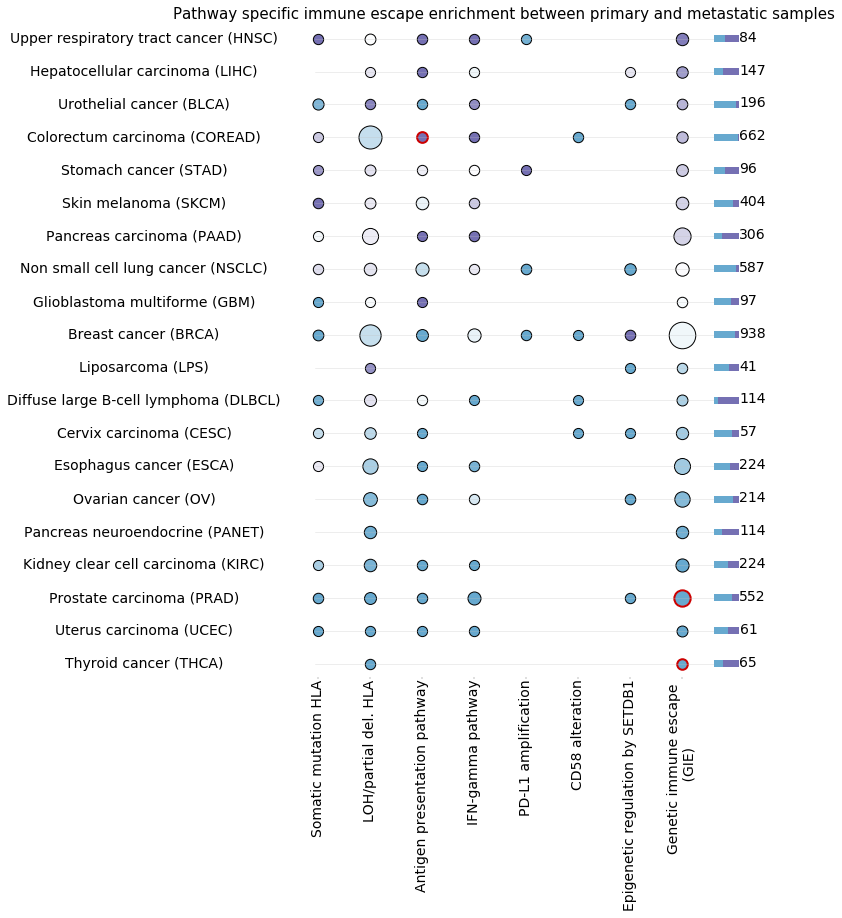

In [34]:
fig,ax=plt.subplots(figsize=(8,12))
N=len(order)
gs = gridspec.GridSpec(ncols=2,nrows=N,height_ratios=[1 for x in range(0,len(order))],width_ratios=[16,1],wspace=0.0)
ax0 = plt.subplot(gs[0]) 
ax1 = plt.subplot(gs[1]) 
axis = [ax0,ax1]
len_columns=len(features)
for i in range(2,N*2,2):
    axis.append(plt.subplot(gs[i],sharex=ax0))
    axis.append(plt.subplot(gs[i+1],sharey=axis[-1]))
i = 0
for j in range(0,len(order)*2,2):
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    ttype_s = order_inverse[i]
    code=df_r_comparison_basic.loc[ttype_s].loc[features]["ttype_code"].values[0]
    v=df_r_comparison_basic.loc[ttype_s].loc[features]["color"].values
    sizes=df_r_comparison_basic.loc[ttype_s].loc[features]["size"].values
    lw=[2 if x else 1  for x in  df_r_comparison_basic.loc[ttype_s].loc[features]["sig"].values]
    edgecolors=["#cc0000" if x else "black"  for x in  df_r_comparison_basic.loc[ttype_s].loc[features]["sig"].values]
    odds=df_r_comparison_basic.loc[ttype_s].loc[features]["log2_odds_ratio"].values
    for c,o in enumerate(odds):
        marker="d"
        if o < -0.5:
            marker="v"
        if o> 0.5:
            marker="^"
        ax.scatter(x=c,y=0,s=sizes[c],color=v[c],edgecolors=edgecolors[c],linewidths=lw[c],clip_on=False,marker="o")
        
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(ttype_s+ " ("+code+")",fontsize=14,rotation=0,verticalalignment="center", labelpad=150)
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylim(-1,1)
    i = i +1

i = 0
for j in range(1,len(order)*2,2):
    ttype_s=order_inverse[i]
    ax = axis[j]
    ax.get_xaxis().set_visible(False)
    met=int(df_r_comparison_basic.loc[ttype_s]["escaped_met"].values[0]) + int(df_r_comparison_basic.loc[ttype_s]["non_escaped_met"].values[0])
    primary=int(df_r_comparison_basic.loc[ttype_s]["escaped_primary"].values[0]) + int(df_r_comparison_basic.loc[ttype_s]["non_escaped_primary"].values[0])
    ax.barh(y=0,width=met,height=0.5,color=pallete["alteration"],clip_on=True)
    ax.barh(y=0,width=primary,height=0.5,left=met,color=pallete["alteration_primary"],clip_on=True)
    ax.annotate(xy=(met+primary+1,-0.2),s=str(int(met)+int(primary)),fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xlim(0,1000)
    ax.set_ylim(-1,1)
    i = i +1

ax=axis[-1]
ax.set_axis_off()
ax=axis[-2]

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(features))))
ax.set_xticklabels(names,rotation=90)
ax.tick_params(axis = 'x', labelsize =14  , pad=0.25,width=0.25, length = 1.5)
#ax0.legend(handles=create_legend(),fontsize=15,bbox_to_anchor=(1.15, 1.5))
ax0.set_title("Pathway specific immune escape enrichment between primary and metastatic samples",fontsize=15)
plt.savefig("../results/figures/figure2/met_vs_primary_detail_circles.pdf", dpi=800,bbox_inches="tight")
plt.show()


In [6]:
df_comb[df_comb["loh_lilac"]].shape[0]

1101

In [7]:
df_comb[(df_comb["loh_lilac"])&(df_comb["mut_hla_lilac"])].shape[0]

33

In [9]:
df_comb[(df_comb["mut_hla_lilac"])].shape[0]

159

In [10]:
33 / 159

0.20754716981132076

In [17]:
df_comb[(df_comb["del_HLA-A"]==1)|(df_comb["del_HLA-B"]==1)|(df_comb["del_HLA-C"]==1)]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,bcells,cd45,cd8,cytox,dc,exhausted_cd8,macroph,mast_cells,neutrophil,nk_cd56n,nk,tcells,th1,treg,infiltration_davoli,cd4_davoli,cd8_davoli,t_cell_grasso,ifn-gamma,systemic_app_pathway,systemic_app_pathway_detail,cd58_pathway,cd58_pathway_detail,ifn_gamma_pathway,ifn_gamma_pathway_detail,checkpoint_pathway,checkpoint_pathway_detail,epigenetic_regulators_pathway,epigenetic_regulators_pathway_detail,targeted_app_pathway_mut_HLA,targeted_app_pathway_loh_HLA,targeted_app_pathway_del_HLA,targeted_app_pathway_partdel_HLA,targeted_escape,non_targeted_escape,genetic_immune_escape,copy_number_neutral_loh_hla
475,DO217836,1.0,0.0,0.0,0,1,1,0,1,1,NaN,NaN,NaN,NaN,CIITA;missense_variant;monoallelic;germline_wt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,12.578453,125.784530,4.156538,0.32,0.6472,False,MSS,LOW,4.624344,131,98,5,144,WARN_LOW_COVERAGE,A*01:01,A*11:01,B*40:06,B*51:01,C*15:02,C*15:02,0.00,0.37,1.28,1.00,1.28,1.00,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,19,0,DO217836,7532,PCAWG,DO217836,fb8b5ff5-4164-4276-b75b-b0ee6bda7329,SP117003,SA542510,HeadAndNeck,Head_and_neck,Upper respiratory tract cancer,HNSC,NaN,NaN,NaN,0.32,1.0,1.0,1.0,True,2.08,MALE,False,MSS,HR_deficient,False,NaN,NaN,NaN,NaN,NaN,NaN,131.0,13138.0,12276.0,63.0,774.0,12256.0,45.0,762.0,1.0,0.0,0.0,WARN_LOW_COVERAGE,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,False,True,True,True,False,True,NaN
1693,DO4695,0.0,1.0,0.0,0,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,10.608103,159.121547,4.961326,0.53,0.2552,False,MSS,LOW,5.953480,580,127,9,197,WARN_LOW_COVERAGE,A*29:02,A*31:01,B*39:10,B*44:03,C*12:03,C*16:01,1.07,0.01,0.20,0.00,1.07,0.01,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,"HLA-A,HLA-C,HLA-B","HLA-A,HLA-C,HLA-B",NaN,NaN,NaN,NaN,82,0,DO4695,5028,PCAWG,DO4695,9ddf2119-a222-4fa5-a9f3-0bec7eeea36b,SP9930,SA46697,Breast,Breast,Breast cancer,BRCA,NaN,NaN,NaN,0.53,1.0,1.0,1.0,True,1.54,FEMALE,False,MSS,HR_deficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580.0,16951.0,15806.0,125.0,994.0,14102.0,98.0,892.0,1665.0,5.0,85.0,WARN_LOW_COVERAGE,True,False,NaN,True,True,True,True,-2.144775,-1.749148,-0.068129,0.343404,-1.95402,0.187051,1.80106,-1.159454,-1.685659,-1.823111,-1.696204,-0.275704,1.731183,-2.356669,2.047469,0.354182,-0.081112,2.693129,2.544041,False,NaN,False,NaN,False,NaN,False,NaN

In [20]:
df_comb[(df_comb["cohort"]=="Hartwig")&(df_comb["genetic_immune_escape"])&(df_comb["cancer_type_code"]=="GBM")]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,bcells,cd45,cd8,cytox,dc,exhausted_cd8,macroph,mast_cells,neutrophil,nk_cd56n,nk,tcells,th1,treg,infiltration_davoli,cd4_davoli,cd8_davoli,t_cell_grasso,ifn-gamma,systemic_app_pathway,systemic_app_pathway_detail,cd58_pathway,cd58_pathway_detail,ifn_gamma_pathway,ifn_gamma_pathway_detail,checkpoint_pathway,checkpoint_pathway_detail,epigenetic_regulators_pathway,epigenetic_regulators_pathway_detail,targeted_app_pathway_mut_HLA,targeted_app_pathway_loh_HLA,targeted_app_pathway_del_HLA,targeted_app_pathway_partdel_HLA,targeted_escape,non_targeted_escape,genetic_immune_escape,copy_number_neutral_loh_hla
96,CPCT02060224T,0.0,0.0,0.0,0,0,0,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,12.398895,123.988950,5.241252,0.71,0.0000,True,MSS,LOW,1.437915,24,25,2,17,PASS,A*02:01,A*02:01,B*07:02,B*51:01,C*07:02,C*14:02,2.92,0.00,2.92,0.00,2.92,0.00,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,NaN,NaN,"HLA-A,HLA-C,HLA-B",NaN,NaN,NaN,4,0,HMF001837A,2131,Hartwig,HMF001837,NaN,NaN,NaN,CNS,CNS,Glioblastoma multiforme,GBM,NaN,Primary,Local,0.71,1.0,1.0,1.0,True,3.30,MALE,True,MSS,HR_proficient,True,NaN,NaN,NaN,NaN,NaN,1.0,24.0,4111.0,3793.0,13.0,300.0,2943.0,9.0,223.0,849.0,4.0,75.0,PASS,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,True,False,True,True,False,True,"HLA-A,HLA-C,HLA-B"
379,DRUP01060020T,0.0,0.0,0.0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,11.548619,115.486188,5.202578,0.67,0.7774,False,MSS,LOW,3.909759,136,51,6,86,PASS,A*03:01,A*03:01,B*07:02,B*47:01,C*06:02,C*07:02,1.01,0.95,0.95,1.01,1.01,0.95,1.0,0.0,0.0,0.0,0.0,0.0,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,33,1,HMF002973A,2148,Hartwig,HMF002973,NaN,NaN,NaN,CNS,CNS,Glioblastoma multiforme,GBM,NaN,Primary,Local,0.67,1.0,1.0,1.0,True,2.02,MALE,False,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,0.0,136.0,11178.0,9895.0,73.0,1197.0,8246.0,32.0,631.0,1641.0,43.0,562.0,PASS,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,True,False,False,False,True,False,True,NaN
1120,CPCT02030532T,0.0,0.0,0.0,1,1,1,1,1,1,TAP1;missense_variant;monoallelic;germline_wt;...,CANX;frameshift_variant;monoallelic;germline_w...,NaN,JAK1;missense_variant;monoallelic;germline_wt;...,NLRC5;missense_variant;monoalle

In [21]:
df_comb[(df_comb["cohort"]=="PCAWG")&(df_comb["genetic_immune_escape"])&(df_comb["cancer_type_code"]=="GBM")]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,bcells,cd45,cd8,cytox,dc,exhausted_cd8,macroph,mast_cells,neutrophil,nk_cd56n,nk,tcells,th1,treg,infiltration_davoli,cd4_davoli,cd8_davoli,t_cell_grasso,ifn-gamma,systemic_app_pathway,systemic_app_pathway_detail,cd58_pathway,cd58_pathway_detail,ifn_gamma_pathway,ifn_gamma_pathway_detail,checkpoint_pathway,checkpoint_pathway_detail,epigenetic_regulators_pathway,epigenetic_regulators_pathway_detail,targeted_app_pathway_mut_HLA,targeted_app_pathway_loh_HLA,targeted_app_pathway_del_HLA,targeted_app_pathway_partdel_HLA,targeted_escape,non_targeted_escape,genetic_immune_escape,copy_number_neutral_loh_hla
560,DO12370,0.0,0.0,0.0,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,13.048250,195.723757,10.686924,0.94,0.6486,False,MSS,LOW,3.174537,245,52,1,97,PASS,A*02:01,A*32:01,B*07:02,B*44:02,C*05:01,C*07:02,0.03,1.01,0.03,1.01,1.01,0.03,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False,NaN,NaN,"HLA-A,HLA-C,HLA-B",NaN,NaN,NaN,120,0,DO12370,5518,PCAWG,DO12370,b8151614-b08f-49a3-ab6f-2e780f765a17,SP26475,SA184257,CNS,CNS,Glioblastoma multiforme,GBM,NaN,NaN,NaN,0.94,1.0,1.0,1.0,True,1.82,MALE,False,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.0,9021.0,8339.0,47.0,627.0,6130.0,32.0,533.0,2195.0,8.0,88.0,PASS,True,False,NaN,True,True,True,True,-2.788076,-1.938239,-2.442808,-2.158106,-2.667200,-1.999746,-0.228538,-3.176982,-2.170366,-3.227706,-2.909596,-2.233925,-1.888969,-2.093293,-1.091389,-0.701936,-1.269938,-0.367377,-0.662475,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,True,False,True,True,False,True,NaN
599,DO11501,0.0,0.0,0.0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,CIITA;missense_variant&splice_region_variant;m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,5.895028,0.92,0.5668,False,MSS,LOW,5.318643,341,95,0,132,PASS,A*03:01,A*68:02,B*07:02,B*42:01,C*07:02,C*17:01,1.02,0.89,1.02,0.89,1.02,0.89,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,89,0,DO11501,5509,PCAWG,DO11501,5fd77ba9-5015-4d8b-86a0-582e5c76bdd6,SP24815,SA155940,CNS,CNS,Glioblastoma multiforme,GBM,NaN,NaN,NaN,0.92,1.0,1.0,1.0,True,2.02,FEMALE,False,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,NaN,341.0,15139.0,14204.0,59.0,849.0,10944.0,39.0,748.0,3237.0,6.0,93.0,PASS,True,False,NaN,True,True,True,True,-2.720829,-1.950423,-2.114175,-1.815142,-2.866678,-2.202311,-0.327101,-2.835612,-2.004218,-3.184829,-2.951494,-2.681297,-1.251539,-2.814529,-0.957201,-0.394089,-1.383361,-0.466509,-1.119182,True,mut CIITA,False

In [22]:
df_comb[(df_comb["cohort"]=="Hartwig")&(df_comb["msi_status"]=="MSI")&(df_comb["cancer_type_code"]=="GBM")]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,bcells,cd45,cd8,cytox,dc,exhausted_cd8,macroph,mast_cells,neutrophil,nk_cd56n,nk,tcells,th1,treg,infiltration_davoli,cd4_davoli,cd8_davoli,t_cell_grasso,ifn-gamma,systemic_app_pathway,systemic_app_pathway_detail,cd58_pathway,cd58_pathway_detail,ifn_gamma_pathway,ifn_gamma_pathway_detail,checkpoint_pathway,checkpoint_pathway_detail,epigenetic_regulators_pathway,epigenetic_regulators_pathway_detail,targeted_app_pathway_mut_HLA,targeted_app_pathway_loh_HLA,targeted_app_pathway_del_HLA,targeted_app_pathway_partdel_HLA,targeted_escape,non_targeted_escape,genetic_immune_escape,copy_number_neutral_loh_hla
393,CPCT02080162T,0.0,0.0,0.0,1,1,1,1,1,1,TAPBP;missense_variant;monoallelic;germline_wt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,13.433517,201.502762,7.924494,0.50,0.6675,False,MSI,HIGH,80.038475,98,1976,42,193,PASS,A*01:01,A*80:01,B*08:01,B*44:03,C*04:01,C*07:01,1.03,0.98,1.03,0.98,0.98,1.03,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,38,0,HMF001180A,2120,Hartwig,HMF001180,NaN,NaN,NaN,CNS,CNS,Glioblastoma multiforme,GBM,NaN,Primary,Local,0.50,1.0,1.0,1.0,True,2.24,MALE,False,MSI,HR_proficient,True,False,True,False,False,True,1.0,98.0,228830.0,215373.0,129.0,13264.0,195655.0,130.0,12886.0,19670.0,12.0,362.0,PASS,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,False,False,False,False,False,False,NaN
1120,CPCT02030532T,0.0,0.0,0.0,1,1,1,1,1,1,TAP1;missense_variant;monoallelic;germline_wt;...,CANX;frameshift_variant;monoallelic;germline_w...,NaN,JAK1;missense_variant;monoallelic;germline_wt;...,NLRC5;missense_variant;monoallelic;germline_wt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,11.456354,171.845304,6.714549,0.73,0.9624,False,MSI,HIGH,339.149353,18,9089,339,741,PASS,A*01:01,A*34:01,B*08:01,B*35:30,C*04:01,C*07:01,0.98,1.01,1.01,0.98,0.98,1.01,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,1,0,HMF002509A,2144,Hartwig,HMF002509,NaN,NaN,NaN,CNS,CNS,Glioblastoma multiforme,GBM,NaN,Primary,Local,0.73,1.0,1.0,1.0,True,2.02,FEMALE,False,MSI,cannot_be_determined,True,False,True,False,False,False,1.0,18.0,969628.0,848696.0,442.0,120191.0,820019.0,672.0,116173.0,27801.0,56.0,3742.0,PASS,True,False,NaN,True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,mut NLRC5,False,NaN,True,mut IFNGR1,Fa